In [1]:
# Some examples of using the torch version of Parametric UMAP
#
# Borrows ideas/code from:
#    * https://github.com/lmcinnes/umap/issues/580
#    * https://colab.research.google.com/drive/1CYxt0GD-Y2zPMOnJIXJWsAhr0LdqI0R6
#
# Uses the MNIST dataset to demonstrate how to use the code in two examples:
#   * Vanilla parametric UMAP using the default arguments
#   * Parametric Umap with a custom encoder, and a decoder for inversion. 

In [2]:

# Load the MNIST dataset (requires torchvision)
# Store dataset in variable X, where X[i] is
# the flattened pixel values for digit i (784=28^2 components).

import torch
import torchvision
from torchvision.transforms import transforms

download_dir = '/tmp'

train_dataset = torchvision.datasets.MNIST(root=f'{download_dir}/.data',
                                           train=True,
                                           transform=transforms.ToTensor(),
                                           download=True)
train_label =  torch.tensor([example[1] for example in train_dataset])
train_tensor = torch.stack([example[0] for example in train_dataset])[:, 0][:, None, ...]
labels = [str(example[1]) for example in train_dataset]
X = train_tensor
X = X.reshape(-1,28*28)

In [3]:
# Basic Usage
# Run ParametricUmap for two epochs with the default parameters

from umap.torch import ParametricUMAP
pumap = ParametricUMAP()
U = pumap.fit_transform(X)

  0%|          | 0/7103 [00:00<?, ?it/s]

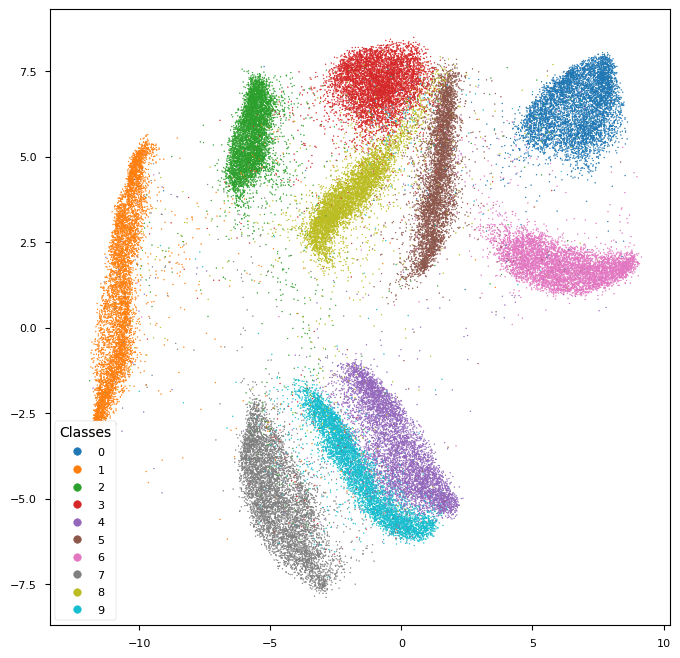

In [4]:
# Visualise the results (requires matplotlib)

import matplotlib.pyplot as plt

with plt.style.context('seaborn-paper'):
    fig,ax = plt.subplots(figsize=(8,8))
    int_labels = [int(y) for y in labels]
    scatter = ax.scatter(*U.T,
                         c=int_labels,
                         s=0.5,
                         cmap=plt.cm.tab10)
    legend = ax.legend(*scatter.legend_elements(),
                        loc="lower left", title="Classes")
    ax.add_artist(legend)
    plt.show()


In [5]:
# We can define our own Encoder, in this example we use
# a CNN to encode the MNIST digits.

# We can also define a decoder to perform inversion and map from the 2D
# UMAP projection back to a digit. To do this, we use a simple CNN as a decoder.

import torch.nn as nn

class ConvEncoder(nn.Module):
    '''Simple CNN to encode 28*28 images into 2d vectors'''
    def __init__(self):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(
                in_channels=1, out_channels=64, kernel_size=3, stride=2, padding=0,
            ),
            nn.PReLU(),
            nn.Conv2d(
                in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=0,
            ),
            nn.Flatten(),
            nn.Linear(128*6*6, 128),
            nn.PReLU(),
            nn.Linear(128, 64),
            nn.PReLU(),
            nn.Linear(64, 2)
        )
    def forward(self, X):
        return self.encoder(X)
    
class ConvDecoder(nn.Module):
    ''' Simple CNN to decode 2d vectors into 28*28 images'''
    def __init__(self):
        super().__init__()

        self.decoder = nn.Sequential(
            nn.Linear(2, 32),
            nn.PReLU(),
            nn.Linear(32, 128),
            nn.PReLU(),
            nn.Linear(128, 64*7*7),
            nn.Unflatten(dim=-1,unflattened_size=(64,7,7)),
            nn.ConvTranspose2d(64, 32, 
                                kernel_size=3, 
                                stride=2, 
                                padding=1, 
                                output_padding=1),
            nn.PReLU(),
            nn.ConvTranspose2d(32, 1, 
                                kernel_size=3, 
                                stride=2, 
                                padding=1, 
                                output_padding=1),
            nn.Sigmoid()
        )
    def forward(self, X):
        return self.decoder(X)

In [6]:
# Run paramtric uamp with our custom encoder/decoder architectures.

pumap = ParametricUMAP(encoder=ConvEncoder(),
                       decoder=ConvDecoder())
U = pumap.fit_transform(X.reshape(-1,1,28,28))

  0%|          | 0/7103 [00:00<?, ?it/s]

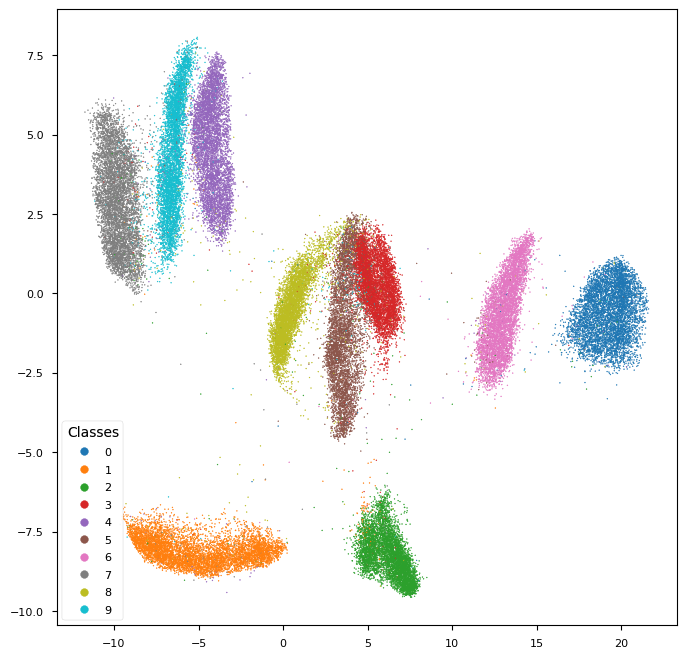

In [7]:
# Visualise the results (requires matplotlib)

import matplotlib.pyplot as plt

with plt.style.context('seaborn-paper'):
    fig,ax = plt.subplots(figsize=(8,8))
    int_labels = [int(y) for y in labels]
    scatter = ax.scatter(*U.T,
                         c=int_labels,
                         s=0.5,
                         cmap=plt.cm.tab10)
    legend = ax.legend(*scatter.legend_elements(),
                        loc="lower left", title="Classes")
    ax.add_artist(legend)
    plt.show()


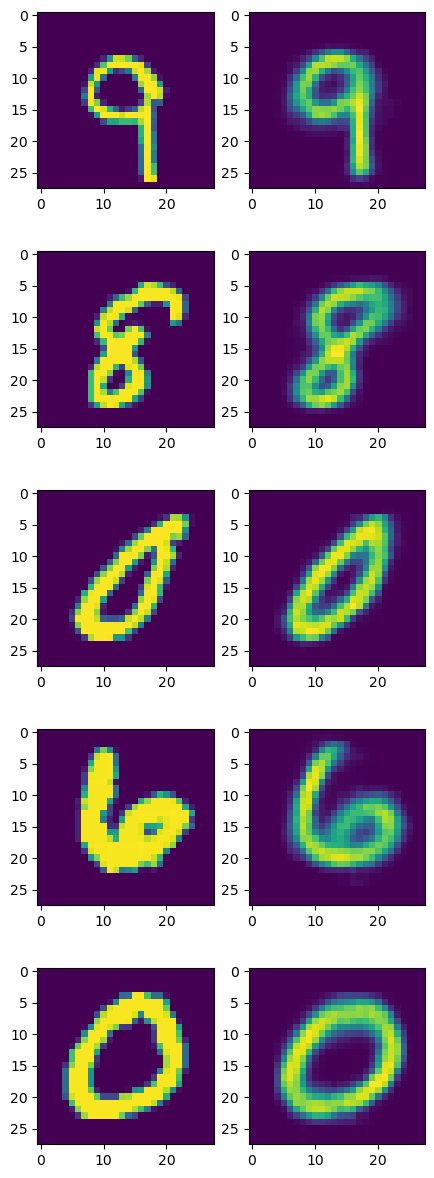

In [8]:
# See how our decoder performs by inverting the encoding of training samples
from matplotlib import pyplot as plt 
import numpy as np 

V = pumap.inverse_transform(U)
fig,axs = plt.subplots(5,2,figsize=(5,15))
axs=axs.flatten()
for i in range(5):
    j = np.random.randint(len(X))
    axs[2*i].imshow(X[j].reshape((28,28)))
    axs[2*i+1].imshow(V[j].reshape((28,28)))

plt.show()